In [166]:
#!pip install torchxrayvision
#!pip install libauc==1.2.0
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import tqdm
import sklearn, sklearn.metrics
import pandas as pd
import torchxrayvision as xrv
import skimage
import cv2
from PIL import Image
from libauc.models import densenet121 as DenseNet121
from libauc.datasets import CheXpert
# tempfile
from tempfile import NamedTemporaryFile

In [286]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# NIH Data
# !mkdir capstone
# !cp /content/gdrive/MyDrive/Capstone/images_001.tar.gz /content/capstone/images

# !tar -xf /content/gdrive/MyDrive/capstone/images-224.tar -C /content/capstone

cp: cannot stat '/content/gdrive/MyDrive/Capstone/images_001.tar.gz': No such file or directory


In [ ]:
# %%time
# !cp /content/gdrive/MyDrive/capstone/CheXpert-v1.0-small.zip /content/
# !mkdir CheXpert
# !unzip -q CheXpert-v1.0-small.zip -d /content/CheXpert/

CPU times: user 2.41 s, sys: 341 ms, total: 2.75 s
Wall time: 5min 35s


In [ ]:
# !ls /content/CheXpert/CheXpert-v1.0-small/train/patient12852/study1/view1_frontal.jpg
# !ls /content/CheXpert/CheXpert-v1.0-small/train/patient49183/study2/view1_frontal.jpg


/content/CheXpert/CheXpert-v1.0-small/train/patient49183/study2/view1_frontal.jpg


In [239]:

def img_to_rgb(img):
    # img.shape is (1, 1, 224, 224)
    # output is (1, 3, 224, 224)
    return img.repeat(1, 3, 1, 1)

In [267]:
import torch.nn as nn
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_nbr = 3
imsize = 224
patience = 50
start_epoch = 0
epochs = 120
print_freq = 20
save_folder = 'models'


class conv2DBatchNormRelu(nn.Module):
    def _init_(
            self,
            in_channels,
            n_filters,
            k_size,
            stride,
            padding,
            bias=True,
            dilation=1,
            with_bn=True,
    ):
        super(conv2DBatchNormRelu, self)._init_()

        conv_mod = nn.Conv2d(int(in_channels),
                             int(n_filters),
                             kernel_size=k_size,
                             padding=padding,
                             stride=stride,
                             bias=bias,
                             dilation=dilation, )

        if with_bn:
            self.cbr_unit = nn.Sequential(conv_mod,
                                          nn.BatchNorm2d(int(n_filters)),
                                          nn.ReLU(inplace=True))
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class segnetDown2(nn.Module):
    def _init_(self, in_size, out_size):
        super(segnetDown2, self)._init_()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def _init_(self, in_size, out_size):
        super(segnetDown3, self)._init_()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module):
    def _init_(self, in_size, out_size):
        super(segnetUp2, self)._init_()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def _init_(self, in_size, out_size):
        super(segnetUp3, self)._init_()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs


class SegNet(nn.Module):
    def _init_(self, n_classes=3, in_channels=3, is_unpooling=True):
        super(SegNet, self)._init_()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling

        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)

    def forward(self, inputs):
        lat, add = self.encode(inputs)
        img = self.decode(lat, add)
        return img

    def encode(self, inputs):
        if inputs.shape[1] == 1:
            inputs = img_to_rgb(inputs)
        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)
        latent = down5
        add = [
            (indices_1, unpool_shape1),
            (indices_2, unpool_shape2),
            (indices_3, unpool_shape3),
            (indices_4, unpool_shape4),
            (indices_5, unpool_shape5),
        ]
        return latent, add

    def decode(self, latent, add):
        [
            (indices_1, unpool_shape1),
            (indices_2, unpool_shape2),
            (indices_3, unpool_shape3),
            (indices_4, unpool_shape4),
            (indices_5, unpool_shape5),
        ] = add

        up5 = self.up5(latent, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)

        return up1[:, [0], :, :]
        

In [144]:
colab = False
dataset_path = "/content/CheXpert/" if colab else "."
img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64606/study1/view1_frontal.jpg"
img_sk = normalize_img(skimage.io.imread(img_path))
img_cv = load_img(img_path)

#img_sk.shape, 
#img_cv.shape
print(img_sk[0, 0,:5, :5])

Setting XRayResizer engine to cv2 could increase performance.
tensor([[ -793.4062,  -875.5726,  -949.6147,  -973.5035,  -985.6731],
        [ -973.5838, -1003.2648, -1018.4674, -1013.6738, -1013.6739],
        [-1009.0696, -1020.5575, -1015.3950, -1019.4103, -1023.4260],
        [-1005.6279, -1017.1158, -1015.9686, -1017.9764, -1019.9842],
        [ -988.8694, -1006.2164, -1009.0848, -1009.0847, -1016.0093]])


In [270]:


def load_img(path):    
    image = cv2.imread(path, 0)
    image = Image.fromarray(image)
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # resize and normalize; e.g., ToTensor()
    image = cv2.resize(image, dsize=(224,224), interpolation=cv2.INTER_LINEAR)  
    image = image/255.0
    __mean__ = np.array([[[0.485, 0.456, 0.406]]])
    __std__ =  np.array([[[0.229, 0.224, 0.225]]]) 
    image = (image-__mean__)/__std__
    image = image.transpose((2, 0, 1)).astype(np.float32)
    #label = np.array(self.targets[idx]).reshape(-1).astype(np.float32)
    return image#, label

def xrv_img_to_classifier(img):
    # img is of shape (224, 224) with values in [-1024, 1024]
    img = img.detach()
    with NamedTemporaryFile(suffix=".png") as f:
        plt.imsave(f.name, img, cmap="Greys_r")
        img = load_img(f.name)
    return torch.tensor(img)

def xrv_img_to_classifier_batch0(img):
    # img is of shape (0, 1, 224, 224) with values in [-1024, 1024]
    # returns (0, 3, 224, 224)
    cf_img = xrv_img_to_classifier(img[0, 0])
    cf_img = cf_img[None]
    return cf_img

def normalize_img(img):
    chexpert_img = xrv.datasets.normalize(img, 255)
    chexpert_img = chexpert_img[None, :, :]
    transform = torchvision.transforms.Compose([
        xrv.datasets.XRayCenterCrop(),
        xrv.datasets.XRayResizer(224),
    ])
    chexpert_img = transform(chexpert_img)
    chexpert_img = torch.from_numpy(chexpert_img).unsqueeze(0)
    return chexpert_img


def plot_cf_img(img):
    img = img.permute(1, 2, 0)
    img = img.cpu().detach().numpy()
    gb_img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(gb_img)
    plt.show()

Shape: (320, 320)
[[35 28 19]
 [12  8  3]
 [ 4  2  1]]


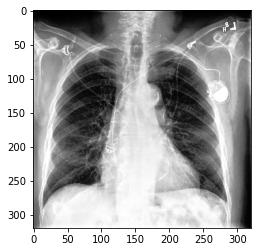

Setting XRayResizer engine to cv2 could increase performance.
Shape: torch.Size([1, 1, 224, 224])
tensor([[[[ -793.4062,  -875.5726,  -949.6147],
          [ -973.5838, -1003.2648, -1018.4674],
          [-1009.0696, -1020.5575, -1015.3950]]]])


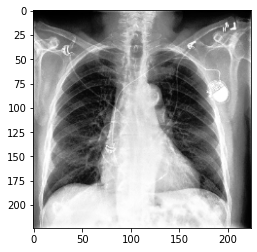

Shape: torch.Size([3, 224, 224])
tensor([[-1.5699, -1.7754, -1.9467],
        [-2.0152, -2.0837, -2.1179],
        [-2.1008, -2.1179, -2.1008]])


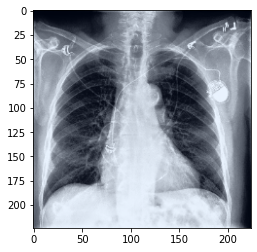

In [261]:
colab = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_path = "/content/CheXpert/" if colab else "."
img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64606/study1/view1_frontal.jpg"
chexpert_img = skimage.io.imread(img_path)


print(f"Shape: {chexpert_img.shape}\n{chexpert_img[:3, :3]}")
plt.imshow(chexpert_img, cmap="Greys_r"); plt.show();

xrv_img = normalize_img(chexpert_img)
print(f"Shape: {xrv_img.shape}\n{xrv_img[:, :, :3, :3]}")
plt.imshow(xrv_img[0, 0], cmap="Greys_r"); plt.show();

img_cf = xrv_img_to_classifier(xrv_img[0, 0])
print(f"Shape: {img_cf.shape}\n{img_cf[0, :3, :3]}")
plot_cf_img(img_cf)

In [ ]:
colab = False
dataset_path = "/content/CheXpert/" if colab else "."
img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64606/study1/view1_frontal.jpg"


torch.Size([1, 512, 3, 3])
(1, 1, 224, 224)


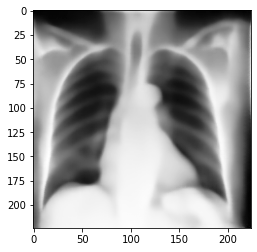

In [229]:
ae_xrv = xrv.autoencoders.ResNetAE(weights="101-elastic")

#out = ae(chexpert_img)
z = ae_xrv.encode(xrv_img)
print(z.shape)
decoded = ae_xrv.decode(z).detach().numpy()
#img_r = out['out'].detach().ngumpy()
print(decoded.shape)
plt.imshow(decoded[0][0], cmap="Greys_r")

In [268]:
ae = torch.load("./weights/autoencoder_v2.pt",  map_location=device);
#print(xrv_img)
z, add = ae.encode(img_to_rgb(xrv_img))
print(z.shape)
img_restore = ae.decode(z, add).detach().numpy()
print(img_restore.shape)


torch.Size([1, 512, 7, 7])
(1, 1, 224, 224)


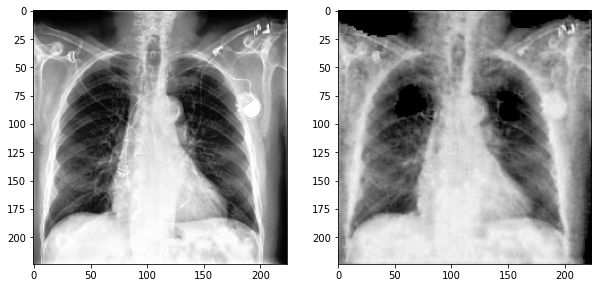

In [263]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))
ax[0].imshow(xrv_img[0, 0], cmap='Greys_r')
ax[1].imshow(img_restore[0], cmap='Greys_r')

# Classifier

In [257]:
classifier_raw = DenseNet121(pretrained=True, last_activation='sigmoid', activations='relu', num_classes=5) # initialize model

classifier_raw.load_state_dict(torch.load('./weights/trained_auc_model.pt', map_location=device)) # load trained model
classifier_raw.eval();

def classifier(img):
    return classifier_raw(xrv_img_to_classifier_batch0(img))

In [106]:
diseases = {0: 'Cardiomegaly', 1: 'Edema', 2: 'Consolidation', 3: 'Atelectasis', 4: 'Pleural Effusion'}

In [271]:
base_labels = classifier(xrv_img)
reconstructed_labels = classifier(ae.decode(*ae.encode(xrv_img)))
#reconstructed_labels = classifier(xrv_img_to_classifier_batch0(ae_xrv.decode(ae_xrv.encode(xrv_img))))
print(f"Base labels:\n{base_labels.detach().numpy()},\n\nReconstructed labels:\n{reconstructed_labels.detach().numpy()}\n\nloss: {F.cross_entropy(base_labels, reconstructed_labels)}")

Base labels:
[[0.181646   0.07644273 0.01042526 0.17867093 0.00815625]],

Reconstructed labels:
[[0.11156677 0.59437007 0.045208   0.08541233 0.01967551]]

loss: 1.3769657611846924


# Grad CAM

In [291]:
def get_saliency(img):
    target_layers = [classifier_raw.features[-1]]
    cam = GradCAMPlusPlus(model=classifier_raw, target_layers=target_layers)

    X = xrv_img_to_classifier_batch0(img)
    grayscale_cam = cam(input_tensor=X)[0]
    #print("cam scale", grayscale_cam.shape)
    return grayscale_cam

# show_saliency(xrv_img)

# Counterfactuals

Setting XRayResizer engine to cv2 could increase performance.
Changing label 0 from 0.18164600431919098 to 0.0
   0 Loss: 27613.2461 | Loss reconstruction: 9747.7295 | Loss classification: 17865.5156
   1 Loss: 27795.0938 | Loss reconstruction: 9729.9092 | Loss classification: 18065.1855
   2 Loss: 27856.1406 | Loss reconstruction: 9712.0420 | Loss classification: 18144.0996
   3 Loss: 27716.3828 | Loss reconstruction: 9694.6279 | Loss classification: 18021.7559
   4 Loss: 27720.5625 | Loss reconstruction: 9677.7031 | Loss classification: 18042.8594
   5 Loss: 27326.8125 | Loss reconstruction: 9661.1621 | Loss classification: 17665.6504
   6 Loss: 26999.5547 | Loss reconstruction: 9644.9170 | Loss classification: 17354.6387
   7 Loss: 27329.5898 | Loss reconstruction: 9628.9404 | Loss classification: 17700.6504
   8 Loss: 27601.5312 | Loss reconstruction: 9613.2832 | Loss classification: 17988.2480
   9 Loss: 27401.9453 | Loss reconstruction: 9597.9307 | Loss classification: 17804.0137

Text(0.5, 1.0, 'Conterfactual\n0.141')

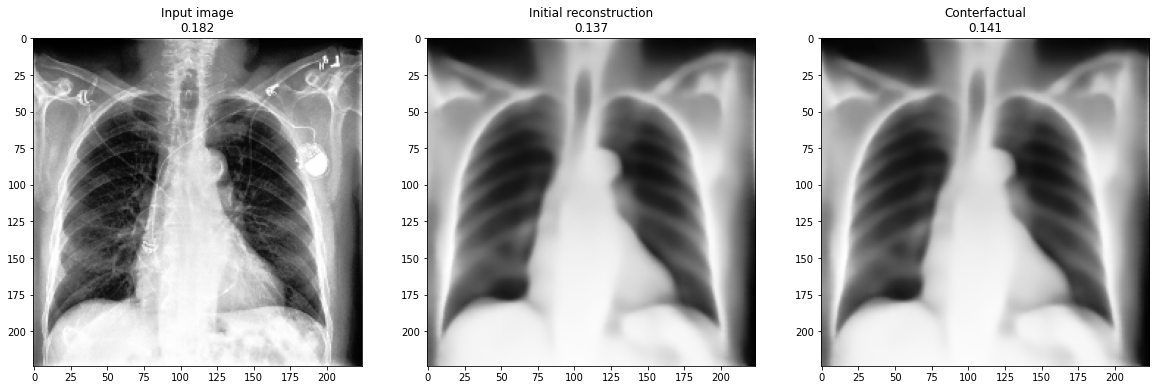

In [326]:
def find_counterfactual(input_img, target_labels, target_weight=3e6, use_xrv=True):
    mask = torch.tensor(get_saliency(input_img))
    
    if use_xrv:
        z_init = ae_xrv.encode(input_img)
    else:
        z_init, add = ae.encode(input_img)
    # optimize z
    z = z_init.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([z], lr=0.001)
    for i in range(10):
        optimizer.zero_grad()
        if use_xrv:
            img_r = ae_xrv.decode(z)
        else:
            img_r = ae.decode(z, add)
        #loss_reconstruction = F.mse_loss(img_r, input_img)
        img_sq_diff = ((img_r - input_img)**2)[0, 0]
        loss_reconstruction = torch.mean(img_sq_diff * (1 - mask))
        classification_label = classifier(img_r)
        # print(f"Classification label: {classification_label} | Target label: {target_labels}")
        loss_classification = F.mse_loss(classification_label, target_labels)*target_weight

        loss = loss_reconstruction + loss_classification
        print(f"{i:4} Loss: {loss.item():.4f} | Loss reconstruction: {loss_reconstruction.item():.4f} | Loss classification: {loss_classification.item():.4f}")
        loss.backward()
        optimizer.step()

    # output image
    if use_xrv:
        img_r_init = ae_xrv.decode(z_init).detach().numpy()
        img_r = ae_xrv.decode(z).detach().numpy()
    else:
        img_r_init = ae.decode(z_init, add).detach().numpy()
        img_r = ae.decode(z, add).detach().numpy()

    return img_r_init, img_r


img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64606/study1/view1_frontal.jpg"
input_img_raw = skimage.io.imread(img_path)
input_img = normalize_img(input_img_raw)

input_labels = classifier(input_img)
feature_index = 0 # 0: ?
# flip label
target_labels = input_labels.clone().detach()
target_labels[0, feature_index] = 0
print(f"Changing label {feature_index} from {input_labels[0, feature_index]} to {target_labels[0, feature_index]}")

img_r_init, img_r = find_counterfactual(input_img, target_labels)


reconstructed_labels = classifier(torch.tensor(img_r_init))
counterfactual_labels = classifier(torch.tensor(img_r))

print(f"Input labels:\n{input_labels.detach().numpy()},\n\nReconstructed labels:\n{reconstructed_labels.detach().numpy()}\n\nCounterfactual labels:\n{counterfactual_labels.detach().numpy()}")

p_input = input_labels[0, feature_index]
p_rec = reconstructed_labels[0, feature_index]
p_cf = counterfactual_labels[0, feature_index]

fig, ax = plt.subplots(1,3, figsize=(20,10))
#ax[0].imshow(input_img_raw, cmap='Greys_r');    ax[0].set_title("Input image");
ax[0].imshow(input_img[0][0], cmap='Greys_r');  ax[0].set_title(f"Input image\n{p_input:.3f}");
ax[1].imshow(img_r_init[0][0], cmap='Greys_r'); ax[1].set_title(f"Initial reconstruction\n{p_rec:.3f}");
ax[2].imshow(img_r[0][0], cmap='Greys_r');      ax[2].set_title(f"Conterfactual\n{p_cf:.3f}")

torch.Size([1, 1, 224, 224])
torch.Size([224, 224])


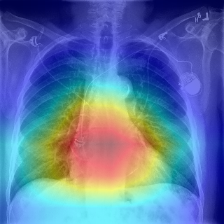

In [311]:

def show_saliency(img, mask):
    print(img.shape)
    # rgb_img = X[index, :, :, :]
    rgb_img = xrv_img_to_classifier(img)
    rgb_img = rgb_img.permute(1, 2, 0)
    rgb_img = rgb_img.cpu().detach().numpy()
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
    visualization = show_cam_on_image(img = rgb_img, mask = mask, use_rgb=True)
    #print(rgb_img.shape)

    
  
    return visualization

print(xrv_img.shape)
mask = get_saliency(xrv_img)
vis = show_saliency(xrv_img[0, 0], mask)
Image.fromarray(vis, 'RGB')